In [3]:
# Copyright (C) 2021-2022 Katherine Xie - All Rights Reserved.

# Generates figures to display results of my research
# Author: Katherine Xie
# Version 2.0 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numpy import random
import pickle
import scipy.stats as st
import itertools 
import seaborn as sns

# Filters dataframe based on neuron type. 
# Establishes a synapse threshold of greater than 1
# data - the dataframe
# col_substr - regex to select for substrings that represent neuron type in columns
# row_substr - regex to select for substrings that represent neuron type in rows
# row_header - header for indices
def filter_neuron_types(data, col_substr, row_substr, idx_header):
    first_column = df.iloc[:, 0] # gets first column to use as row indices
    # columns
    new_df = data.filter(regex=col_substr, axis='columns') 
    
    # rows
    new_df.insert(0, idx_header, first_column, True) # inserts column with row labels into the new dataframe
    new_df.set_index(idx_header, inplace=True) # sets inserted column as dataframe indicies
    new_df = new_df.filter(regex=row_substr, axis='index')
    
    # establishing a threshold of num synapses > 1 to count as a connection
    num_rows = len(new_df)
    # loops thru rows of new_df
    for i in range(num_rows):
        row = new_df.iloc[i] # gets row
        new_row = np.where(row == 1, 0, row) # if synaspse num = 1, change to 0
        new_df.iloc[i] = new_row
    
    return new_df

# Normalizes weights by column's sum in a pandas df
# df - dataframe
# sum_of_w - the sum of the weights
def normalize_weights_df(df, sum_of_w):
    col = len(df.columns)
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = df.iloc[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            df.iloc[:,c] = [i/s for i in w]
    return sum_of_w * df

# Normalizes weights by column's sum in a numpy array
# arr - numpy array
# sum_of_w - the sum of the weights
def normalize_weights_np(arr, sum_of_w):
    col = len(arr[0])
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = arr[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            arr[:,c] = [i/s for i in w]
    return sum_of_w * arr

# normalizes weights by the row's sum in a pandas df
def normalize_kc_weights_df(df, sum_of_w):
    row = len(df.index)
    for r in range(row):
        w = df.iloc[r]
        s = sum(abs(w)) # sum of row
        if (s != 0):
            df.iloc[r] = [i/s for i in w]
    return sum_of_w * df

# normalizes weights by the row's sum in a numpy array
def normalize_kc_weights_np(arr, sum_of_w):
    row = len(arr)
    for r in range(row):
        w = arr[r]
        s = sum(abs(w)) # sum of row
        if (s != 0):
            arr[r] = [i/s for i in w]
    return sum_of_w * arr

# get the number kc from string arr
# a - num kcs removed
def get_num_kc(string, a):
    nums = np.zeros(a)
    for i in range(a):
        end = False
        s = string[i]
        j = 1
        num_str = ""
        while end == False:
            # end loop if space is reached
            if s[-j] == " ": 
                end = True
            else:
                num_str = s[-j] + num_str
            j += 1
        nums[i] = int(num_str)
    return nums

# mbon - index of mbon
def count_num_removed(kc_mbon, nums, mbon):
    count = 0
    nums = nums.astype(int)
    for i in range(len(nums)):
        if kc_mbon.iloc[nums[i], mbon] != 0:
            count += 1
    return count


df = pd.read_csv('connectivity matrix table 1.csv') # matrix of connections between neurons

# FILTER DATA FOR PNs (rows) to KCs (columns) CONNECTIONS -> pn_kc
pn_kc = filter_neuron_types(df, "(?=.*KC)(?=.*left)", "(?=.*PN)(?=.*left)", "Presynaptic PNs") # filter w/ regex PNs and KCs

# normalize weights
pn_kc = normalize_weights_df(pn_kc, 1)

# FILTER DATA FOR KCs TO MBONs CONNECTIONS -> kc_to_mbon
kc_mbon = filter_neuron_types(df, "(?=.*MBON)(?=.*left)", "(?=.*KC)(?=.*left)", "Presynaptic KCs") # filter w/ regex for KCs and MBON lefts

# take out MBONs with no KC connections
kc_mbon = kc_mbon.drop(kc_mbon.loc[:, (kc_mbon.sum(axis=0) == 0)], axis=1)

# adding a fictional MBON
fict_weights = np.full(len(kc_mbon), 0.1) # initializing all weights at 0.1
kc_mbon['MBON-fict'] = fict_weights

# normalizing weights
kc_mbon = normalize_kc_weights_df(kc_mbon, 1)
kc_mbon = kc_mbon.fillna(0)

# Set numbers
num_kcs = len(pn_kc.columns)
num_pns = len(pn_kc) # number of PNs (40), also = number of dimensions of the odor
num_mbons = len(kc_mbon.columns)
R = 10 # number of realizations of training
K = 23 # number of KC removal sets
T = 5000

# color palette (19 colors)
colors = ['steelblue', 'darkorange', 'forestgreen', 'crimson', 'mediumpurple', 'rosybrown', 
          'pink', 'goldenrod', 'darkturquoise', 'thistle', 'lightsteelblue', 'peachpuff', 
          'lightgreen', 'lightsalmon', 'sienna', 'orchid', 'gray', 'khaki', 'lightblue']

kc_mbon

,MBON-a1 left,MBON-a2 left,MBON-b1 left,MBON-b2 left,MBON-c1 left,MBON-d1 left,MBON-e1 left,MBON-e2 left,MBON-g1 left,MBON-g2 left,MBON-h1 left,MBON-h2 left,MBON-i1 left,MBON-k1 left,MBON-m1 left,MBON-n1 left,MBON-o1 left,MBON-q1 left,MBON-fict
Presynaptic KCs,,,,,,,,,,,,,,,,,,,
1 claw KC left,0.025141,0.031427,0.081710,0.043997,0.251414,0.062854,0.131992,0.043997,0.050283,0.043997,0.037712,0.062854,0.056568,0.000000,0.031427,0.0,0.012571,0.031427,0.000629
1 claw KC left,0.055134,0.027567,0.103377,0.103377,0.186079,0.089593,0.117161,0.020675,0.110269,0.075810,0.013784,0.048243,0.034459,0.000000,0.000000,0.0,0.013784,0.000000,0.000689
1 claw KC left,0.068446,0.027379,0.068446,0.095825,0.150582,0.061602,0.082136,0.027379,0.075291,0.061602,0.041068,0.061602,0.068446,0.020534,0.013689,0.0,0.013689,0.061602,0.000684
1 claw KC left,0.060740,0.027609,0.132523,0.110436,0.215351,0.049696,0.104914,0.033131,0.071784,0.022087,0.038653,0.077305,0.027609,0.000000,0.016565,0.0,0.000000,0.011044,0.000552
1 claw KC left,0.018171,0.018171,0.072683,0.048455,0.381587,0.084797,0.048455,0.000000,0.024228,0.066626,0.054512,0.042399,0.030285,0.012114,0.030285,0.0,0.000000,0.066626,0.000606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young KC left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
young KC left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
young KC left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000


# Control Results

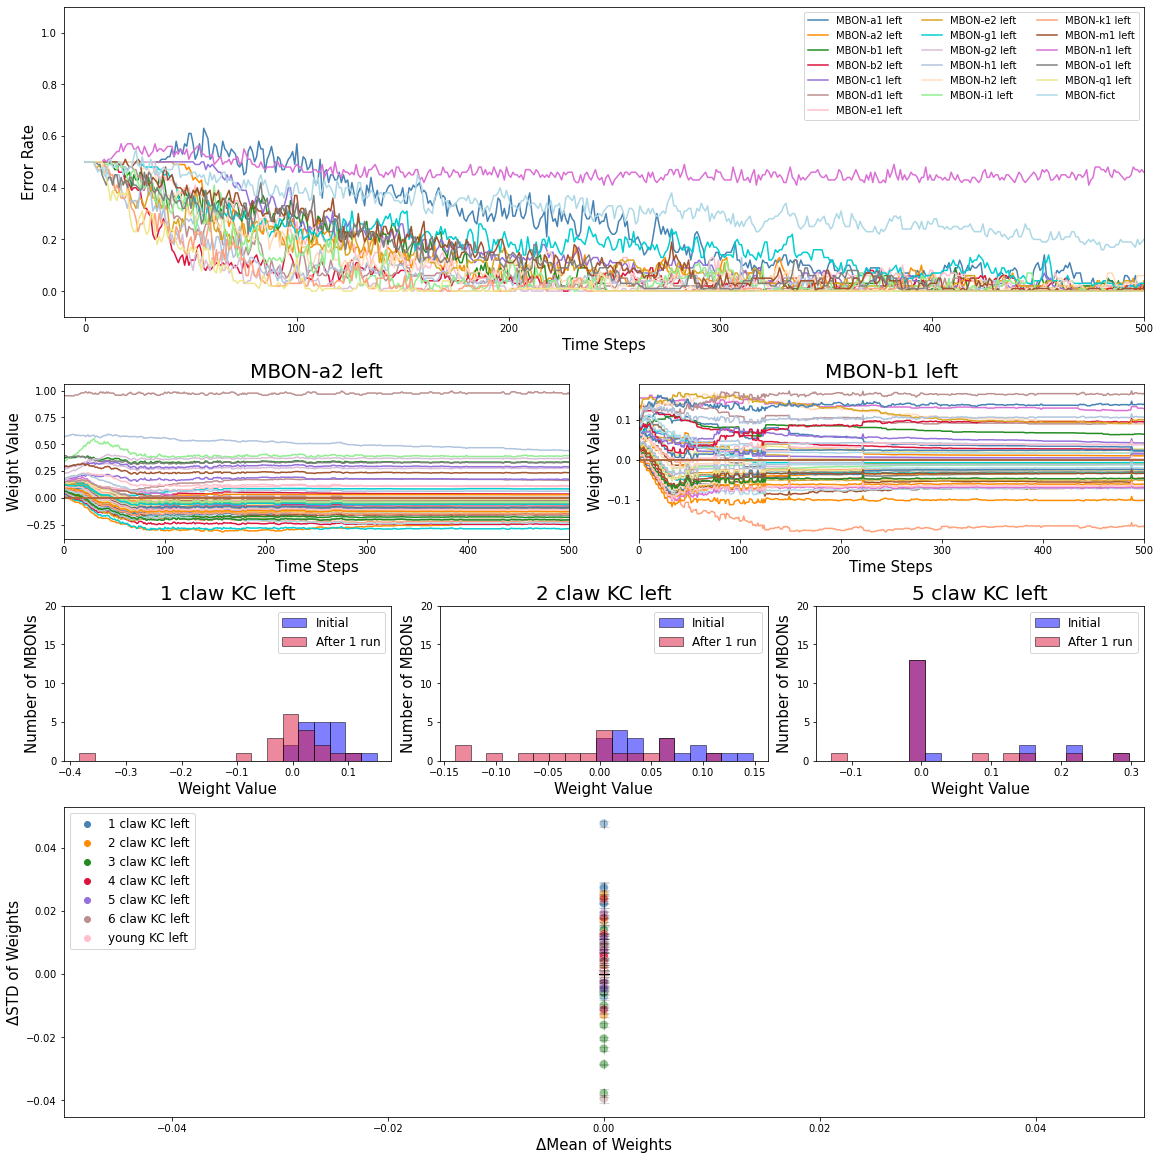

In [11]:
axis_fontsize = 15
title_fontsize = 20
fig2 = plt.figure(figsize=(16,16), constrained_layout=True)
gs2 = fig2.add_gridspec(ncols=6, nrows=6)

# 2A AVERAGE ERROR OVER TIME
f2_ax1 = fig2.add_subplot(gs2[0:2, :])

with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/all-error-rates1.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)    
    
# with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control2/all-error-rates1.pkl', 'rb') as f:
#     error_over_time2 = pickle.load(f)

# # concatenate arrays from both runs
# error_rate_over_time = np.concatenate((error_over_time1, error_over_time2), axis = 0)

avg_error = np.mean(error_rate_over_time, axis=0)

x = np.linspace(0, 5000, 5000)
for i in range(num_mbons):
    f2_ax1.plot(x, avg_error[:,i], label = kc_mbon.columns[i], color = colors[i])
    
f2_ax1.legend(fontsize=10, loc=1, ncol = 3)
f2_ax1.set_ylim(-0.1, 1.1)
f2_ax1.set_xlim(-10, 500)
f2_ax1.set_xlabel("Time Steps", fontsize=axis_fontsize)
f2_ax1.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 2B WEIGHTS OVER TIME ACROSS KCS FOR MBON-a2 left
f2_ax2 = fig2.add_subplot(gs2[2, 0:3])

with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/total-weights1.pkl', 'rb') as f:
    weights_over_time = pickle.load(f) 

# with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control2/total-weights1.pkl', 'rb') as f:
#     weights_over_time2 = pickle.load(f) 

# # concatenate arrays from both runs
# weights_over_time = np.concatenate((weights_over_time1, weights_over_time2), axis = 0)

x = np.linspace(0, 5000, 5000)

for k in range(num_kcs):
    f2_ax2.plot(x, weights_over_time[0, :, k, 1]) # plot weights over time for MBON-a2 left (index=1)
f2_ax2.set_title("{}".format(kc_mbon.columns[1]), fontsize=title_fontsize)
f2_ax2.set_xlim(0, 500)
f2_ax2.set_xlabel("Time Steps", fontsize=axis_fontsize)
f2_ax2.set_ylabel("Weight Value", fontsize=axis_fontsize)

# 2C WEIGHTS OVER TIME ACROSS KCS FOR MBON-b1 left
f2_ax3 = fig2.add_subplot(gs2[2, 3:])

x = np.linspace(0, 5000, 5000)

for k in range(num_kcs):
    f2_ax3.plot(x, weights_over_time[0, :, k, 2]) # plot weights over time for MBON-b1 left (index=2)
f2_ax3.set_title("{}".format(kc_mbon.columns[2]), fontsize=title_fontsize)
f2_ax3.set_xlim(0, 500)
f2_ax3.set_xlabel("Time Steps", fontsize=axis_fontsize)
f2_ax3.set_ylabel("Weight Value", fontsize=axis_fontsize)

# 2D 1 claw KC left (index=2) WEIGHT DISTRIBUTION
f2_ax4 = fig2.add_subplot(gs2[3, 0:2])
    
# average final weights over 10
avg_weights = np.mean(weights_over_time, axis=0)

x = np.zeros((3, num_mbons))
x[0] = kc_mbon.iloc[2]
x[1] = weights_over_time[0, -1, 2] # final weights after realization #1 of training
x[2] = avg_weights[-1, 2]

# initial weights
f2_ax4.hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='Initial')

# final weights after 1 training run
f2_ax4.hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='crimson', alpha=0.5, label='After 1 run')

f2_ax4.set_title(kc_mbon.index[2], fontsize=title_fontsize)
f2_ax4.set_xlabel('Weight Value', fontsize=axis_fontsize)
f2_ax4.set_ylabel('Number of MBONs', fontsize=axis_fontsize)
f2_ax4.set_ylim(0, 20)
f2_ax4.legend(fontsize=12)

# 2E 2 claw KC left (index=18) WEIGHT DISTRIBUTION
f2_ax5 = fig2.add_subplot(gs2[3, 2:4])

x = np.zeros((3, num_mbons))
x[0] = kc_mbon.iloc[18]
x[1] = weights_over_time[0, -1, 18] # final weights after realization #1 of training
x[2] = avg_weights[-1, 18]

# initial weights
f2_ax5.hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='Initial')

# final weights after 1 training run
f2_ax5.hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='crimson', alpha=0.5, label='After 1 run')

f2_ax5.set_title(kc_mbon.index[18], fontsize=title_fontsize)
f2_ax5.set_xlabel('Weight Value', fontsize=axis_fontsize)
f2_ax5.set_ylabel('Number of MBONs', fontsize=axis_fontsize)
f2_ax5.set_ylim(0, 20)
f2_ax5.legend(fontsize=12)

# 2F 5 claw KC left (index=67) WEIGHT DISTRIBUTION
f2_ax6 = fig2.add_subplot(gs2[3, 4:])

x = np.zeros((3, num_mbons))
x[0] = kc_mbon.iloc[61]
x[1] = weights_over_time[0, -1, 61] # final weights after realization #1 of training
x[2] = avg_weights[-1, 61]

# initial weights
f2_ax6.hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='Initial')

# final weights after 1 training run
f2_ax6.hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='crimson', alpha=0.5, label='After 1 run')

f2_ax6.set_title(kc_mbon.index[67], fontsize=title_fontsize)
f2_ax6.set_xlabel('Weight Value', fontsize=axis_fontsize)
f2_ax6.set_ylabel('Number of MBONs', fontsize=axis_fontsize)
f2_ax6.set_ylim(0, 20)
f2_ax6.legend(fontsize=12)

# 2G SCATTER PLOT OF DELTA MEAN & STD OF WEIGHTS
f2_ax7 = fig2.add_subplot(gs2[4:, :])

# weights_over_time shape = (20, 5000, 110, 19) -> R, T, num_kcs, num_mbons
init_weights = np.mean(abs(weights_over_time[:, 0]), axis=2)
init_std_weights = np.std(weights_over_time[:, 0], axis=2)

smooth_final_weights = np.mean(abs(weights_over_time[:, -50:]), axis=1)
# smooth_final_weights = abs(weights_over_time[:, -1])
mean_weights = np.mean(smooth_final_weights, axis = 2)
std_weights = np.std(smooth_final_weights, axis = 2)

# organize into dataframe 
# x axis - difference in means of final and initial KC weights
x = mean_weights - init_weights

# y axis - difference in stds of final and initial KC weights
y = std_weights - init_std_weights

# average mean and std across realizations
avg_of_mean_weights = np.mean(x, axis = 0)
avg_of_std_weights = np.mean(y, axis = 0)

# create dataframe to organize scatter plot values
names = kc_mbon.index
df = pd.DataFrame({'Type of KC':names, 'Mean':avg_of_mean_weights, 'STD':avg_of_std_weights})

# Set color palette
sns.set_palette(sns.color_palette(colors))

# get sem
sem_m = st.sem(x, axis=0)
sem_s = st.sem(y, axis=0)

# plot scatter plots of std vs mean
f2_ax7.errorbar(x=df['Mean'], y=df['STD'], xerr=sem_m, yerr=sem_s, capsize=5, color='black', alpha=0.15,
                linewidth=1, linestyle='', marker=None)
sns.scatterplot(ax=f2_ax7, x=df['Mean'], y=df['STD'], hue=df['Type of KC'], alpha=0.5, s=80)

f2_ax7.set_xlabel('ΔMean of Weights', fontsize=axis_fontsize)
f2_ax7.set_ylabel('ΔSTD of Weights', fontsize=axis_fontsize)
f2_ax7.set_xlim(-0.05, .05)
f2_ax7.legend(loc='upper left', fontsize=12)

# Relative Targeted Ablation

Text(0, 0.5, 'Average % Ablated per KC Type')

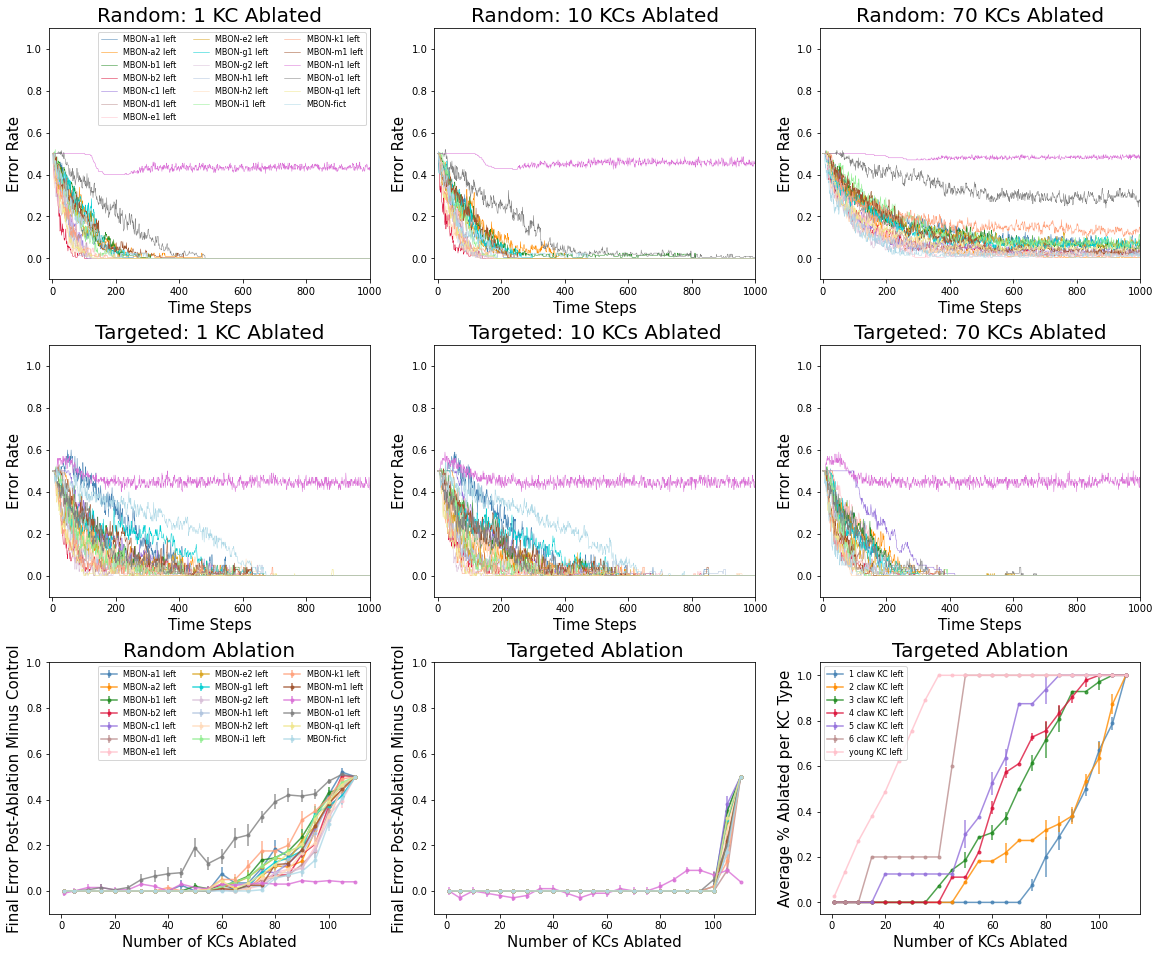

In [12]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 8
fig4 = plt.figure(figsize=(16,30), constrained_layout=True)
gs4 = fig4.add_gridspec(ncols=6, nrows=15)

# 4A ERROR OVER TIME (REMOVED 1) - RANDOM
f4_ax1 = fig4.add_subplot(gs4[6:8, 0:2])

# list of num of KCs removed
num_removed = np.ones(23)
num_removed[1:] = np.linspace(5, 110, 22)
num_removed = num_removed.astype(int)

with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/random-ablation/all-error-rates2.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/random-ablation2/all-error-rates2.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) 

# concatenate arrays from both runs
r_error_rate_over_time = np.concatenate((error_over_time1, error_over_time2), axis = 1)

avg_error = np.mean(r_error_rate_over_time, axis=1)

x = np.linspace(0, 5000, 5000)

for i in range(num_mbons):
    f4_ax1.plot(x, avg_error[0, : ,i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax1.set_ylim(-0.1, 1.1)
f4_ax1.set_xlim(-10, 1000)
f4_ax1.legend(fontsize=legend_fontsize, loc=1, ncol=3)
f4_ax1.set_title("Random: {} KC Ablated".format(num_removed[0]), fontsize=title_fontsize)
f4_ax1.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax1.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4B ERROR OVER TIME (REMOVED 10) - RANDOM
f4_ax2 = fig4.add_subplot(gs4[6:8, 2:4])

for i in range(num_mbons):
    f4_ax2.plot(x, avg_error[2, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax2.set_ylim(-0.1, 1.1)
f4_ax2.set_xlim(-10, 1000)
f4_ax2.set_title("Random: {} KCs Ablated".format(num_removed[2]), fontsize=title_fontsize)
f4_ax2.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax2.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4C ERROR OVER TIME (REMOVED 70) - RANDOM
f4_ax3 = fig4.add_subplot(gs4[6:8, 4:])

for i in range(num_mbons):
    f4_ax3.plot(x, avg_error[14, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax3.set_ylim(-0.1, 1.1)
f4_ax3.set_xlim(-10, 1000)
f4_ax3.set_title("Random: {} KCs Ablated".format(num_removed[14]), fontsize=title_fontsize)
f4_ax3.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax3.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4D ERROR OVER TIME (REMOVED 1) - TARGETED
f4_ax4 = fig4.add_subplot(gs4[8:10, 0:2])

with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-rel-targeted-ablation/all-error-rates4.pkl', 'rb') as f:
    t_error_rate_over_time = pickle.load(f)
    
# with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-targeted-ablation2/all-error-rates2.pkl', 'rb') as f:
#     error_over_time2 = pickle.load(f)
    
# t_error_rate_over_time = np.concatenate((error_over_time1, error_over_time2), axis = 1)

avg_error = np.mean(t_error_rate_over_time, axis=1)

x = np.linspace(0, 5000, 5000)

for i in range(num_mbons):
    f4_ax4.plot(x, avg_error[0, : ,i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax4.set_ylim(-0.1, 1.1)
f4_ax4.set_xlim(-10, 1000)
f4_ax4.set_title("Targeted: {} KC Ablated".format(num_removed[0]), fontsize=title_fontsize)
f4_ax4.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax4.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4E ERROR OVER TIME (REMOVED 10) - TARGETED
f4_ax5 = fig4.add_subplot(gs4[8:10, 2:4])

for i in range(num_mbons):
    f4_ax5.plot(x, avg_error[2, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax5.set_ylim(-0.1, 1.1)
f4_ax5.set_xlim(-10, 1000)
f4_ax5.set_title("Targeted: {} KCs Ablated".format(num_removed[2]), fontsize=title_fontsize)
f4_ax5.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax5.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4F ERROR OVER TIME (REMOVED 70) - TARGETED
f4_ax6 = fig4.add_subplot(gs4[8:10, 4:])

for i in range(num_mbons):
    f4_ax6.plot(x, avg_error[14, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f4_ax6.set_ylim(-0.1, 1.1)
f4_ax6.set_xlim(-10, 1000)
f4_ax6.set_title("Targeted: {} KCs Ablated".format(num_removed[14]), fontsize=title_fontsize)
f4_ax6.set_xlabel("Time Steps", fontsize=axis_fontsize)
f4_ax6.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 4G ERROR VS NUM KCS ABLATED - RANDOM
f4_ax7 = fig4.add_subplot(gs4[10:12, 0:2])

num_mbons = 19
K = 23
T = 5000
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/all-error-rates1.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons
    
# with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control2/all-error-rates1.pkl', 'rb') as f:
#     error_over_time2 = pickle.load(f)

# # concatenate arrays from both runs
# error_control = np.concatenate((error_over_time1, error_over_time2), axis = 0)

# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 
x = []       
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(r_error_rate_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(r_error_rate_over_time[i], axis=0)
    std_y[i] = st.sem(r_error_rate_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
    f4_ax7.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.8, 
                    label=kc_mbon.columns[p], ms=3, c=colors[p])

f4_ax7.set_xlabel("Number of KCs Ablated", fontsize=axis_fontsize)
f4_ax7.set_ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
f4_ax7.set_ylim(-0.1, 1.0)
f4_ax7.set_title("Random Ablation", fontsize=title_fontsize)
f4_ax7.legend(fontsize=legend_fontsize, loc=1, ncol=3)

# 4H ERROR VS NUM KCS ABLATED - TARGETED
f4_ax8 = fig4.add_subplot(gs4[10:12, 2:4])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(t_error_rate_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(t_error_rate_over_time[i], axis=0)
    std_y[i] = st.sem(t_error_rate_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
    f4_ax8.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.8, 
                     label=kc_mbon.columns[p], ms=3, c=colors[p])

f4_ax8.set_xlabel("Number of KCs Ablated", fontsize=axis_fontsize)
f4_ax8.set_ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
f4_ax8.set_ylim(-0.1, 1.0)
f4_ax8.set_title("Targeted Ablation", fontsize=title_fontsize)

# 4I PERCENTAGE OF EACH KC TYPE ABLATED VS NUMBER ABLATED
f4_ax9 = fig4.add_subplot(gs4[10:12, 4:6])

# import data
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-rel-targeted-ablation/kcs-removed4.pkl', 'rb') as f:
    kc_names = pickle.load(f) # K, R, index of a KC removed

# with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-targeted-ablation2/kcs-removed3.pkl', 'rb') as f:
#     kc_names2 = pickle.load(f) # K, R, index of a KC removed

# kc_names1 = np.array(kc_names1, dtype='object')
# kc_names2 = np.array(kc_names2, dtype='object')

# kc_names = np.concatenate((kc_names1, kc_names2), axis = 1)

kc_types = ['1 claw KC left', '2 claw KC left', '3 claw KC left', '4 claw KC left', '5 claw KC left', 
         '6 claw KC left', 'young KC left']

# find number of each type of KC in the network
list_names = list(kc_mbon.index)
type_counts = np.zeros(7)
for t in range(7):
    type_counts[t] = list_names.count(kc_types[t])
    
# x-axis -> number of KCs removed
x = np.ones(23)
x[1:] = np.linspace(5, 110, 22)
x = x.astype(int)

# format names
for r in range(R):
    for a in range(len(kc_names)):
        sub_list = kc_names[a][r] # r = realization
        for b in range(len(sub_list)):
            s = sub_list[b]
            idx = s.index('t') + 1 # index after t in "left"
            kc_names[a][r][b] = s[0:idx]

# y-axis -> percentage of each type out of the total number of kcs ablated
y = np.zeros((R, 7, K)) # 7 = number of KC types
for r in range(R):
    for k in range(K):
        names = kc_names[k][r] # the k removed KCs, for realization r
        for t in range(7):
            y[r, t, k] = names.count(kc_types[t]) / float(type_counts[t])
            
# plot averaged plot over the 10 realizations
# calculate average percentages across realizations
y_avg = np.mean(y, axis=0)

# calculate std of percentages across realizations
y_std = np.std(y, axis=0)

# plot
for t in range(7):
    f4_ax9.errorbar(x, y_avg[t], yerr=y_std[t], alpha=0.8, marker='.', label=kc_types[t], c=colors[t])
f4_ax9.set_title("Targeted Ablation", fontsize=title_fontsize)    
f4_ax9.legend(fontsize=legend_fontsize)
f4_ax9.set_xlabel("Number of KCs Ablated", fontsize=axis_fontsize)
f4_ax9.set_ylabel("Average % Ablated per KC Type", fontsize=axis_fontsize)

# Targeted Pruning

Text(0, 0.5, 'Average % Pruned per KC Type')

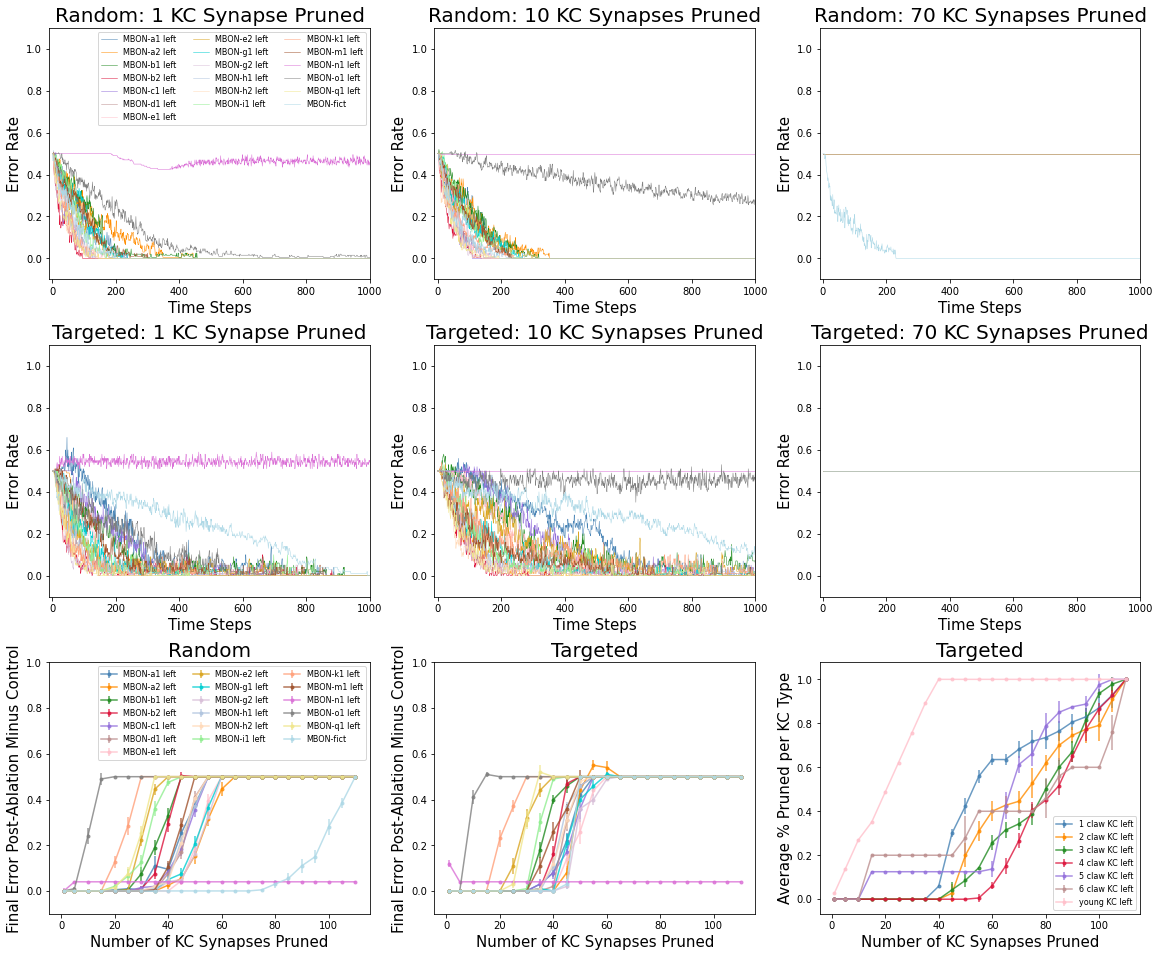

In [7]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 8
fig6 = plt.figure(figsize=(16,30), constrained_layout=True)
gs6 = fig6.add_gridspec(ncols=6, nrows=15)

# 6A ERROR OVER TIME (REMOVED 1) - RANDOM
f6_ax1 = fig6.add_subplot(gs6[6:8, 0:2])

# list of num of KCs removed
num_removed = np.ones(23)
num_removed[1:] = np.linspace(5, 110, 22)
num_removed = num_removed.astype(int)

with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/random-pruning/all-error-rates4.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)

with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/random-pruning2/all-error-rates4.pkl', 'rb') as f:
    error_over_time2 = pickle.load(f) 

# concatenate arrays from both runs
r_error_rate_over_time = np.concatenate((error_over_time1, error_over_time2), axis = 1)

avg_error = np.mean(r_error_rate_over_time, axis=1)

x = np.linspace(0, 5000, 5000)

for i in range(num_mbons):
    f6_ax1.plot(x, avg_error[0, : ,i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax1.set_ylim(-0.1, 1.1)
f6_ax1.set_xlim(-10, 1000)
f6_ax1.legend(fontsize=legend_fontsize, loc=1, ncol=3)
f6_ax1.set_title("Random: {} KC Synapse Pruned".format(num_removed[0]), fontsize=title_fontsize)
f6_ax1.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax1.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6B ERROR OVER TIME (REMOVED 10) - RANDOM
f6_ax2 = fig6.add_subplot(gs6[6:8, 2:4])

for i in range(num_mbons):
    f6_ax2.plot(x, avg_error[2, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax2.set_ylim(-0.1, 1.1)
f6_ax2.set_xlim(-10, 1000)
f6_ax2.set_title("Random: {} KC Synapses Pruned".format(num_removed[2]), fontsize=title_fontsize)
f6_ax2.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax2.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6C ERROR OVER TIME (REMOVED 70) - RANDOM
f6_ax3 = fig6.add_subplot(gs6[6:8, 4:])

for i in range(num_mbons):
    f6_ax3.plot(x, avg_error[14, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax3.set_ylim(-0.1, 1.1)
f6_ax3.set_xlim(-10, 1000)
f6_ax3.set_title("Random: {} KC Synapses Pruned".format(num_removed[14]), fontsize=title_fontsize)
f6_ax3.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax3.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6D ERROR OVER TIME (REMOVED 1) - TARGETED
f6_ax4 = fig6.add_subplot(gs6[8:10, 0:2])

with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-targeted-pruning/all-error-rates3.pkl', 'rb') as f:
    t_error_rate_over_time = pickle.load(f)
    
# with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-pruning2/all-error-rates5.pkl', 'rb') as f:
#     error_over_time2 = pickle.load(f)
    
# t_error_rate_over_time = np.concatenate((error_over_time1, error_over_time2), axis = 1)

avg_error = np.mean(t_error_rate_over_time, axis=1)

x = np.linspace(0, 5000, 5000)

for i in range(num_mbons):
    f6_ax4.plot(x, avg_error[0, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax4.set_ylim(-0.1, 1.1)
f6_ax4.set_xlim(-10, 1000)
f6_ax4.set_title("Targeted: {} KC Synapse Pruned".format(num_removed[0]), fontsize=title_fontsize)
f6_ax4.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax4.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6E ERROR OVER TIME (REMOVED 10) - TARGETED
f6_ax5 = fig6.add_subplot(gs6[8:10, 2:4])

for i in range(num_mbons):
    f6_ax5.plot(x, avg_error[2, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax5.set_ylim(-0.1, 1.1)
f6_ax5.set_xlim(-10, 1000)
f6_ax5.set_title("Targeted: {} KC Synapses Pruned".format(num_removed[2]), fontsize=title_fontsize)
f6_ax5.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax5.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6F ERROR OVER TIME (REMOVED 70) - TARGETED
f6_ax6 = fig6.add_subplot(gs6[8:10, 4:])

for i in range(num_mbons):
    f6_ax6.plot(x, avg_error[14, :, i], label = kc_mbon.columns[i], linewidth = 0.5, color = colors[i])
    
f6_ax6.set_ylim(-0.1, 1.1)
f6_ax6.set_xlim(-10, 1000)
f6_ax6.set_title("Targeted: {} KC Synapses Pruned".format(num_removed[14]), fontsize=title_fontsize)
f6_ax6.set_xlabel("Time Steps", fontsize=axis_fontsize)
f6_ax6.set_ylabel("Error Rate", fontsize=axis_fontsize)

# 6G ERROR VS NUM KCS ABLATED - RANDOM
f6_ax7 = fig6.add_subplot(gs6[10:12, 0:2])

num_mbons = 19
K = 23
T = 5000

# import data   
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/all-error-rates1.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

# with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control2/all-error-rates1.pkl', 'rb') as f:
#     error_over_time2 = pickle.load(f)

# # concatenate arrays from both runs
# error_control = np.concatenate((error_over_time1, error_over_time2), axis = 0)

# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 
x = []       
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(r_error_rate_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(r_error_rate_over_time[i], axis=0)
    std_y[i] = st.sem(r_error_rate_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
    f6_ax7.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.8, 
                    label=kc_mbon.columns[p], ms=3, c=colors[p])

f6_ax7.set_xlabel("Number of KC Synapses Pruned", fontsize=axis_fontsize)
f6_ax7.set_ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
f6_ax7.set_ylim(-0.1, 1.0)
f6_ax7.set_title("Random", fontsize=title_fontsize)
f6_ax7.legend(fontsize=legend_fontsize, loc=1, ncol=3)

# 6H ERROR VS NUM KCS ABLATED - TARGETED
f6_ax8 = fig6.add_subplot(gs6[10:12, 2:4])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(t_error_rate_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(t_error_rate_over_time[i], axis=0)
    std_y[i] = st.sem(t_error_rate_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
    f6_ax8.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.8, 
                     label=kc_mbon.columns[p], ms=3, c=colors[p])

f6_ax8.set_xlabel("Number of KC Synapses Pruned", fontsize=axis_fontsize)
f6_ax8.set_ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
f6_ax8.set_ylim(-0.1, 1.0)
f6_ax8.set_title("Targeted", fontsize=title_fontsize)

# 6I AVERAGE PERCENTAGE PRUNED OF EACH TYPE VS NUMBER OF KC SYNAPSES PRUNED
f6_ax9 = fig6.add_subplot(gs6[10:12, 4:6])

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-targeted-pruning/kcs-removed3.pkl', 'rb') as f:
    kc_names = pickle.load(f)

# with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-pruning2/kcs-removed5.pkl', 'rb') as f:
#     kc_names2 = pickle.load(f) # K, R, index of a KC removed

# kc_names1 = np.array(kc_names1, dtype='object')
# kc_names2 = np.array(kc_names2, dtype='object')

# kc_names = np.concatenate((kc_names1, kc_names2), axis = 1)
        
# x-axis -> number of KCs removed
x = np.ones(23)
x[1:] = np.linspace(5, 110, 22)
x = x.astype(int)

# format names
for r in range(R):
    for a in range(len(kc_names)):
        sub_list = kc_names[a][r] # r = realization
        for b in range(len(sub_list)):
            s = sub_list[b]
            idx = s.index('t') + 1 # index after t in "left"
            kc_names[a][r][b] = s[0:idx]

# y-axis -> percentage of each type out of the total number of kcs ablated
y = np.zeros((R, 7, K)) # 7 = number of KC types
for r in range(R):
    for k in range(K):
        names = kc_names[k][r] # the k removed KCs, for realization r
        for t in range(7):
            y[r, t, k] = names.count(kc_types[t]) / float(type_counts[t])
            
# plot averaged plot over the 10 realizations
# calculate average percentages across realizations
y_avg = np.mean(y, axis=0)

# calculate std of percentages across realizations
y_std = np.std(y, axis=0)

# plot
for t in range(7):
    f6_ax9.errorbar(x, y_avg[t], yerr=y_std[t], alpha=0.8, marker='.', label=kc_types[t], c=colors[t])
f6_ax9.set_title("Targeted", fontsize=title_fontsize)    
f6_ax9.legend(fontsize=legend_fontsize, loc=4)
f6_ax9.set_xlabel("Number of KC Synapses Pruned", fontsize=axis_fontsize)
f6_ax9.set_ylabel("Average % Pruned per KC Type", fontsize=axis_fontsize)